# Mini-Project 3
**Author**: Farkhad Kuanyshkereyev<br>
**Course**: Data Science<br>
**Professor**: Sepinoud Azimi Rashti

## **Step 1 - Importing Packages**

In [1]:
# Installing necessary packages

!pip install contractions

     |████████████████████████████████| 321 kB 15.6 MB/s 
     |████████████████████████████████| 284 kB 49.5 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85440 sha256=9c83e2c321c4095c563fc2c97bb57bb8de79766e57b427ad4f9ca3dd57735a37
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [2]:
# Importing necessary packages and defining drop words constant

from collections import defaultdict
from google.colab import files
from matplotlib import cm, pylab
from matplotlib.colors import ListedColormap
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

import contractions
import datetime
import io
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
import regex as re
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')

DROP_WORDS = ['\'s', 'biden', 'joe', 'trump', 'donald', 'trumps', 'bidens']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Step 2 - Data Collection**

**NOTE:** The Data Collection Part is written in the script attached to the project. It **does not work in Jupyter** due to a single commented line inside the *twint* package. If you still want to collect data from Twitter, then please refer to the collect_data.py script attached to the project. The project report contains further information about this issue.

## **Step 3 - Data Cleaning**

In [3]:
# NOTE: The name of the data file is written into the following variable

# Uploading the TRUMP data file

file_name = 'trump.csv'
uploaded = files.upload()
trump_df = pd.read_csv(io.BytesIO(uploaded[file_name]))

Saving trump.csv to trump.csv


In [4]:
# Uploading the BIDEN data file

file_name = 'biden.csv'
uploaded = files.upload()
biden_df = pd.read_csv(io.BytesIO(uploaded[file_name]))

Saving biden.csv to biden.csv


In [7]:
biden_df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1323410490215772162,1323410490215772162,2020-11-03 01:43:43 EET,2020-11-03,01:43:43,300,202396203,patriciaheaton,Patricia Heaton,NaN,"A reminder: neither Trump nor Biden, neither t...",en,[],[],[],515,1630,13968,[],[],https://twitter.com/PatriciaHeaton/status/1323...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1323408365385588736,1323408365385588736,2020-11-03 01:35:16 EET,2020-11-03,01:35:16,300,778763106289758208,jennaellisesq,Jenna Ellis,NaN,Police now reporting that the Biden bus incide...,en,[],[],[],272,3791,11488,[],[],https://twitter.com/JennaEllisEsq/status/13234...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1323408157566066688,1323408157566066688,2020-11-03 01:34:27 EET,2020-11-03,01:34:27,300,292929271,charliekirk11,Charlie Kirk,NaN,They wouldn't be sending the National Guard in...,en,[],[],[],338,4407,22665,[],[],https://twitter.com/charliekirk11/status/13234...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1323394413473705984,1323305624214642693,2020-11-03 00:39:50 EET,2020-11-03,00:39:50,300,2580732109,npsmajor,J.C.,NaN,@mashimari @balleralert You know who I never s...,en,[],[],[],56,779,10429,[],[],https://twitter.com/npsmajor/status/1323394413...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'mashimari', 'name': 'maría',...",NaN,NaN,NaN,NaN
4,1323393122290847744,1323393122290847744,2020-11-03 00:34:42 EET,2020-11-03,00:34:42,300,20715936,connieschultz,Connie Schultz,NaN,“So when Sherrod tells me to come to Ohio the ...,en,[],[],['https://pbs.twimg.com/media/El2jBvNXEAIpeMN....,198,980,16029,[],[],https://twitter.com/ConnieSchultz/status/13233...,False,NaN,1,https://pbs.twimg.com/media/El2jBvNXEAIpeMN.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [8]:
# Defining main feature columns

FEATURE_COLUMNS = [
  'id',
  'created_at',
  'date',
  'tweet',
  'likes_count'
]

In [9]:
# Defining the function that drops every non-relevant row and column

def clean_dataframe(df):
    df.drop_duplicates(inplace=True)
    df = df[df['language'] == 'en']
    df = df[FEATURE_COLUMNS]
    return df

In [10]:
# Cleaning Trump and Biden dataframes

trump_df = clean_dataframe(trump_df)
biden_df = clean_dataframe(biden_df)

In [11]:
# Showing 5 rows from the Trump dataframe

trump_df.head()

,id,created_at,date,tweet,likes_count
0,1323410616191754241,2020-11-03 01:44:13 EET,2020-11-03,The day Trump leaves office will be one of the...,15896
1,1323410490215772162,2020-11-03 01:43:43 EET,2020-11-03,"A reminder: neither Trump nor Biden, neither t...",13968
2,1323409554567094272,2020-11-03 01:40:00 EET,2020-11-03,Donald Trump is the most corrupt president in ...,202988
3,1323409509599993856,2020-11-03 01:39:49 EET,2020-11-03,FREE EL CHAPO RIP TRUMP https://t.co/RMBOqX05XW,21622
4,1323408472239726592,2020-11-03 01:35:42 EET,2020-11-03,The President is the greatest political showma...,10277


In [12]:
# Showing general information about the Trump dataframe

trump_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4981 entries, 0 to 5018
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           4981 non-null   int64 
 1   created_at   4981 non-null   object
 2   date         4981 non-null   object
 3   tweet        4981 non-null   object
 4   likes_count  4981 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 233.5+ KB


In [13]:
# Showing 5 rows from the Biden dataframe

biden_df.head()

,id,created_at,date,tweet,likes_count
0,1323410490215772162,2020-11-03 01:43:43 EET,2020-11-03,"A reminder: neither Trump nor Biden, neither t...",13968
1,1323408365385588736,2020-11-03 01:35:16 EET,2020-11-03,Police now reporting that the Biden bus incide...,11488
2,1323408157566066688,2020-11-03 01:34:27 EET,2020-11-03,They wouldn't be sending the National Guard in...,22665
3,1323394413473705984,2020-11-03 00:39:50 EET,2020-11-03,@mashimari @balleralert You know who I never s...,10429
4,1323393122290847744,2020-11-03 00:34:42 EET,2020-11-03,“So when Sherrod tells me to come to Ohio the ...,16029


In [14]:
# Showing general information about the Biden dataframe

biden_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3359 entries, 0 to 3378
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           3359 non-null   int64 
 1   created_at   3359 non-null   object
 2   date         3359 non-null   object
 3   tweet        3359 non-null   object
 4   likes_count  3359 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 157.5+ KB


## **Step 4 - Data Preprocessing**

In [15]:
# Preprocessing Tweets and applying tokenization on them

stop_words = set(stopwords.words('english'))

def get_tokenized_title(df):
    tokenized_title = df['tweet'].apply(lambda x: [contractions.fix(word) for word in x.split()])
    tokenized_title = pd.Series([' '.join(x) for x in tokenized_title])
    tokenized_title = tokenized_title.str.lower()
    tokenized_title = tokenized_title.apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))
    tokenized_title = tokenized_title.apply(word_tokenize)
    tokenized_title = tokenized_title.apply(lambda x: [word for word in x if word not in stop_words])
    tokenized_title = [' '.join(x) for x in tokenized_title]
    return tokenized_title

trump_df['tokenized_tweet'] = get_tokenized_title(trump_df)
biden_df['tokenized_tweet'] = get_tokenized_title(biden_df)

In [16]:
# Showing 5 rows from the Trump dataframe with the tokenized_tweet column

trump_df.head()

,id,created_at,date,tweet,likes_count,tokenized_tweet
0,1323410616191754241,2020-11-03 01:44:13 EET,2020-11-03,The day Trump leaves office will be one of the...,15896,day trump leaves office one celebrated days hu...
1,1323410490215772162,2020-11-03 01:43:43 EET,2020-11-03,"A reminder: neither Trump nor Biden, neither t...",13968,reminder neither trump biden neither democrats...
2,1323409554567094272,2020-11-03 01:40:00 EET,2020-11-03,Donald Trump is the most corrupt president in ...,202988,donald trump corrupt president modern history ...
3,1323409509599993856,2020-11-03 01:39:49 EET,2020-11-03,FREE EL CHAPO RIP TRUMP https://t.co/RMBOqX05XW,21622,free el chapo rip trump httpstcormboqx05xw
4,1323408472239726592,2020-11-03 01:35:42 EET,2020-11-03,The President is the greatest political showma...,10277,president greatest political showman ever seen...


In [17]:
# Showing 5 rows from the Biden dataframe with the tokenized_tweet column

biden_df.head()

,id,created_at,date,tweet,likes_count,tokenized_tweet
0,1323410490215772162,2020-11-03 01:43:43 EET,2020-11-03,"A reminder: neither Trump nor Biden, neither t...",13968,reminder neither trump biden neither democrats...
1,1323408365385588736,2020-11-03 01:35:16 EET,2020-11-03,Police now reporting that the Biden bus incide...,11488,police reporting biden bus incident shows bide...
2,1323408157566066688,2020-11-03 01:34:27 EET,2020-11-03,They wouldn't be sending the National Guard in...,22665,would sending national guard chicago tonight j...
3,1323394413473705984,2020-11-03 00:39:50 EET,2020-11-03,@mashimari @balleralert You know who I never s...,10429,mashimari balleralert know never see behaving ...
4,1323393122290847744,2020-11-03 00:34:42 EET,2020-11-03,“So when Sherrod tells me to come to Ohio the ...,16029,sherrod tells come ohio day come ohio joe bide...


## **Step 5 - Exploratory Data Analysis**

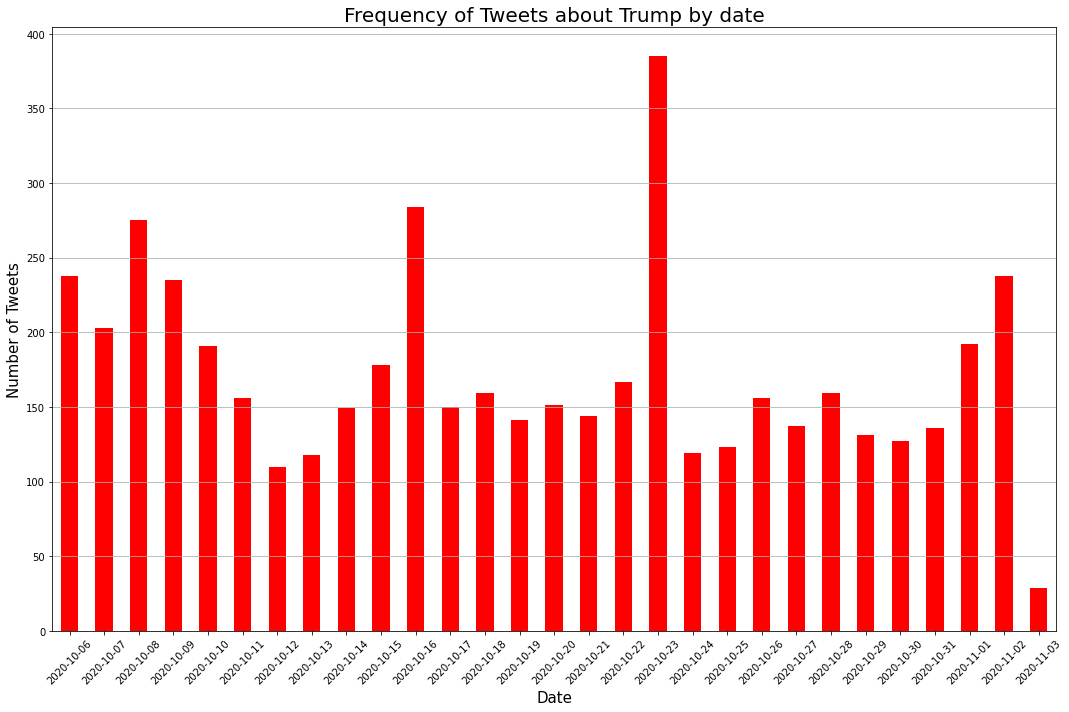

In [18]:
# Plotting the frequency of tweets by dates for the Trump dataframe

fig, ax = plt.subplots(figsize=(15, 10))
trump_df['date'].value_counts().sort_index().plot(kind='bar', color='red')
plt.title('Frequency of Tweets about Trump by date', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of Tweets', fontsize=15)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show();

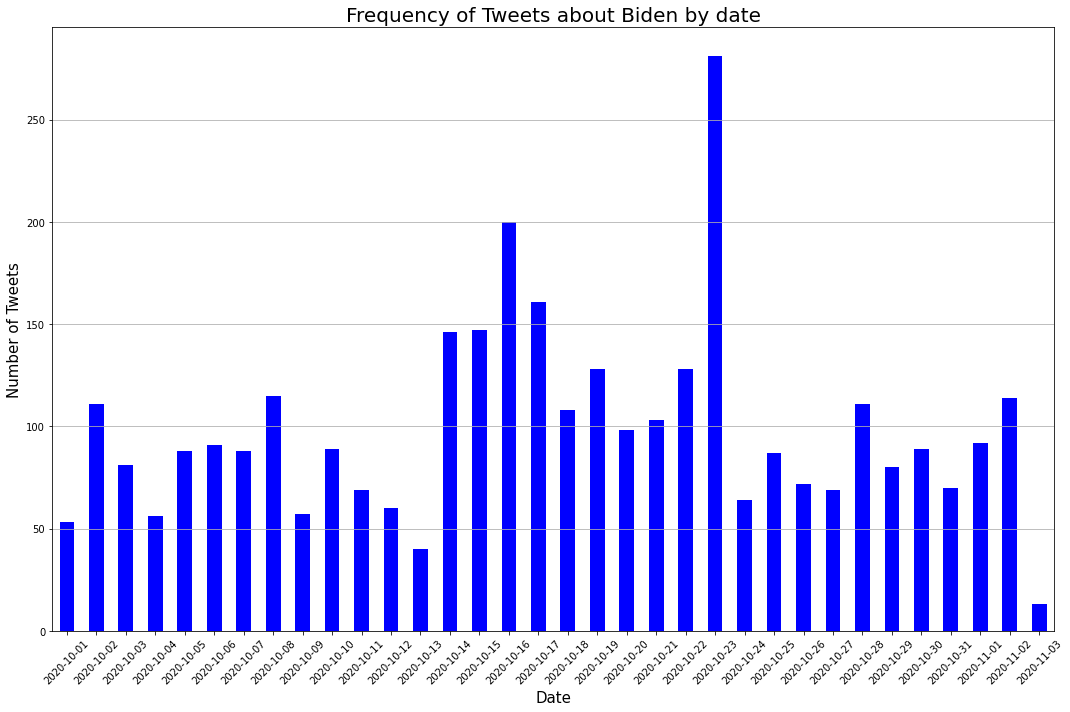

In [19]:
# Plotting the frequency of tweets by dates for the Biden dataframe

fig, ax = plt.subplots(figsize=(15, 10))
biden_df['date'].value_counts().sort_index().plot(kind='bar', color='blue')
plt.title('Frequency of Tweets about Biden by date', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of Tweets', fontsize=15)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show();

In [20]:
# Showing the information about the likes count of Tweets with the 'Trump' keyword

trump_df['likes_count'].describe()

count    4.981000e+03
mean     2.850747e+04
std      4.307307e+04
min      5.149000e+03
25%      1.189400e+04
50%      1.724100e+04
75%      2.922300e+04
max      1.275006e+06
Name: likes_count, dtype: float64

In [21]:
# Showing the information about the likes count of Tweets with the 'Biden' keyword

biden_df['likes_count'].describe()

count      3359.000000
mean      26941.768383
std       33344.572845
min        6486.000000
25%       12659.000000
50%       17665.000000
75%       28672.000000
max      743471.000000
Name: likes_count, dtype: float64

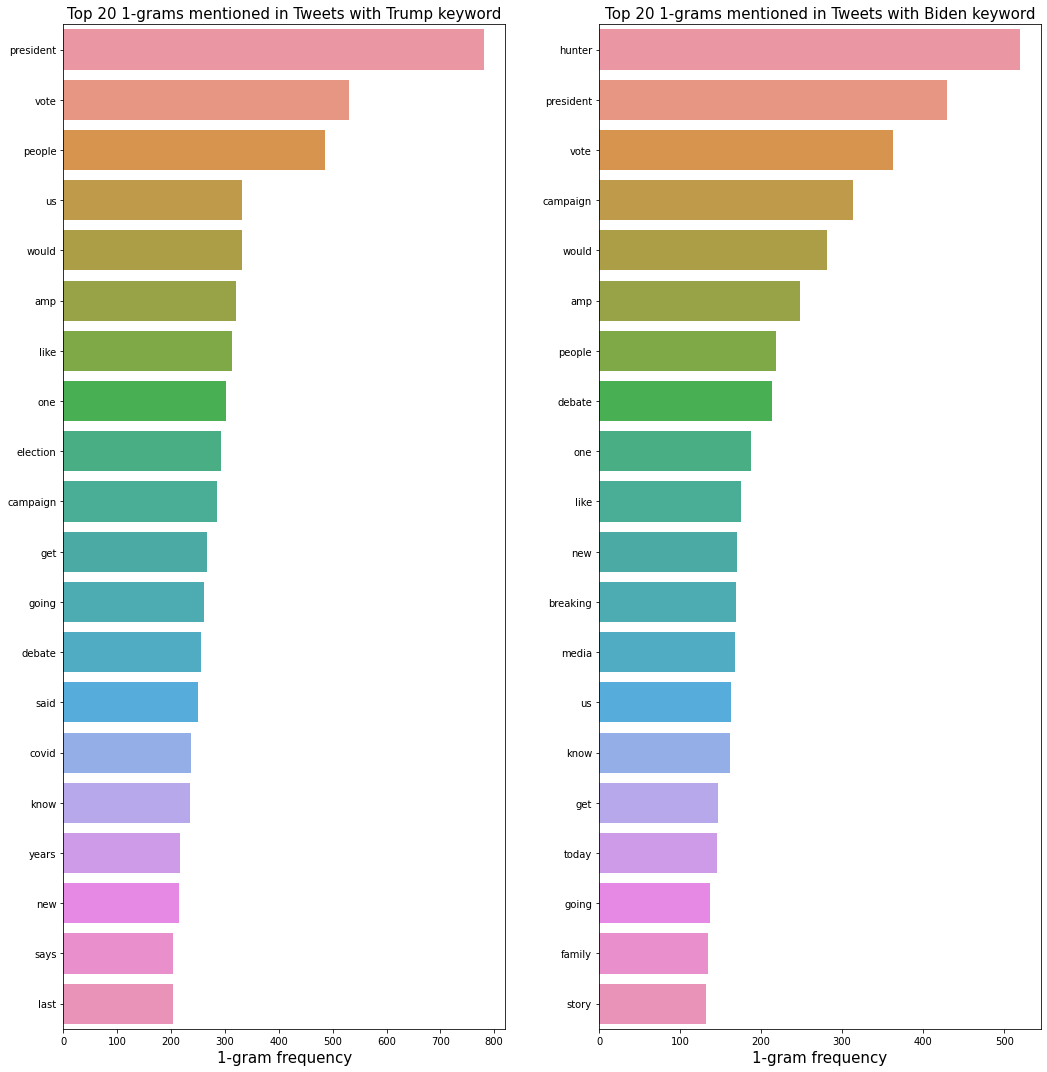

In [29]:
# Plotting top unigrams, bigrams, and trigrams from titles of news

def get_corpus(text):
    text = text.str.split()
    text = text.values.tolist()
    corpus = [word for i in text for word in i]
    return corpus

def plot_comparison_top_ngrams_barcharts(text1, text2, top_size=20, n=2):
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(15)
    fig.set_figheight(15)

    corpus1 = get_corpus(text1)
    corpus2 = get_corpus(text2)

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = []

        for word, idx in vec.vocabulary_.items():
            drop_word_detected = False

            for drop_word in DROP_WORDS:
                if drop_word in word:
                    drop_word_detected = True

            if drop_word_detected:
                continue

            words_freq.append((word, sum_words[0, idx]))

        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:top_size]

    top_n_bigrams1 = _get_top_ngram(text1, n)[:top_size]
    top_n_bigrams2 = _get_top_ngram(text2, n)[:top_size]
    x1, y1 = map(list, zip(*top_n_bigrams1))
    x2, y2 = map(list, zip(*top_n_bigrams2))

    ax[0].set_xlabel(f'{n}-gram frequency', fontsize=15)
    ax[0].set_title(f'Top {top_size} {n}-grams mentioned in Tweets with Trump keyword', fontsize=15)
    ax[1].set_xlabel(f'{n}-gram frequency', fontsize=15)
    ax[1].set_title(f'Top {top_size} {n}-grams mentioned in Tweets with Biden keyword', fontsize=15)
    sns.barplot(x=y1, y=x1, ax=ax[0])
    sns.barplot(x=y2, y=x2, ax=ax[1])
    fig.tight_layout()

plot_comparison_top_ngrams_barcharts(
    text1=trump_df['tokenized_tweet'], 
    text2=biden_df['tokenized_tweet'],
    top_size=20,
    n=1    
)

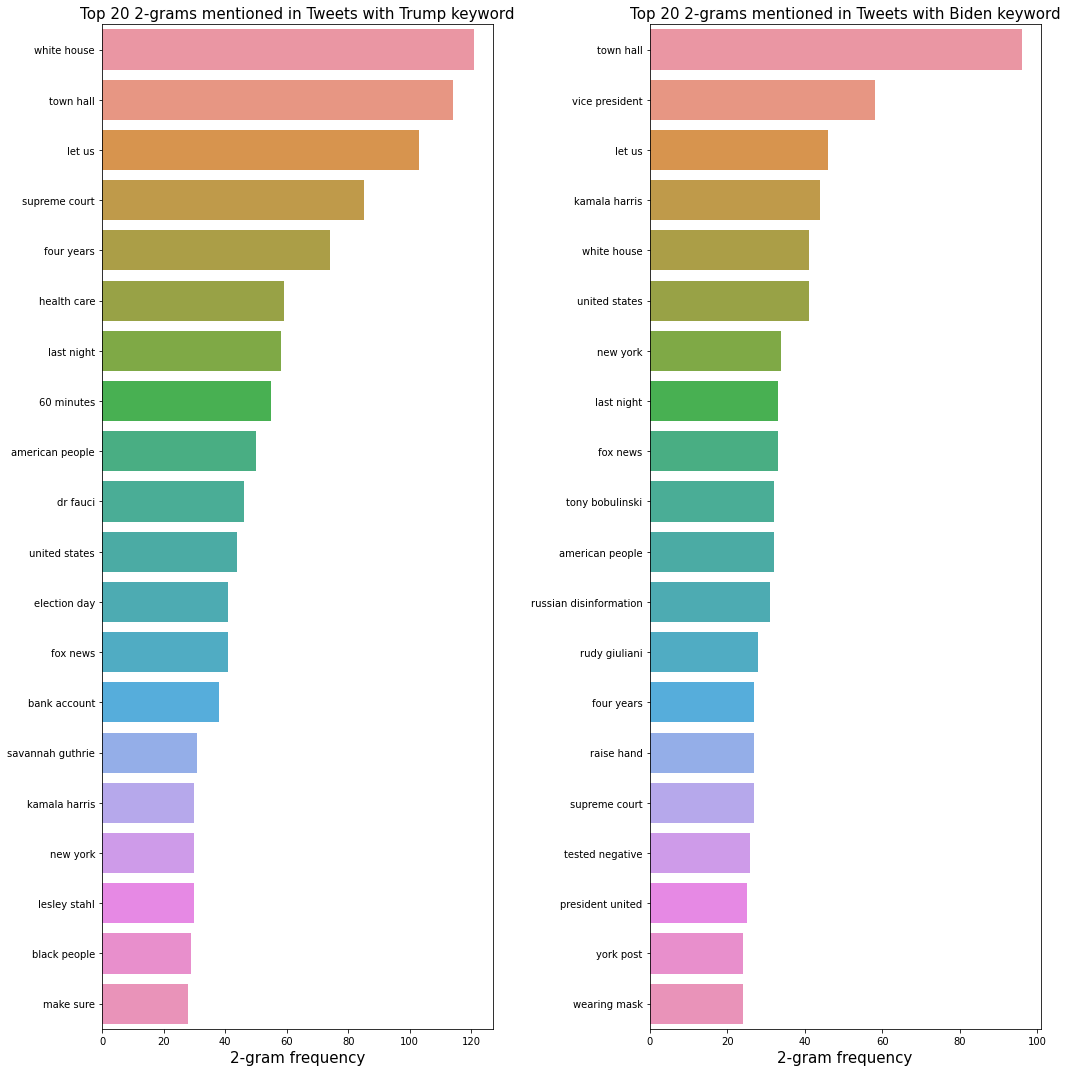

In [30]:
plot_comparison_top_ngrams_barcharts(
    text1=trump_df['tokenized_tweet'], 
    text2=biden_df['tokenized_tweet'],
    top_size=20,
    n=2    
)

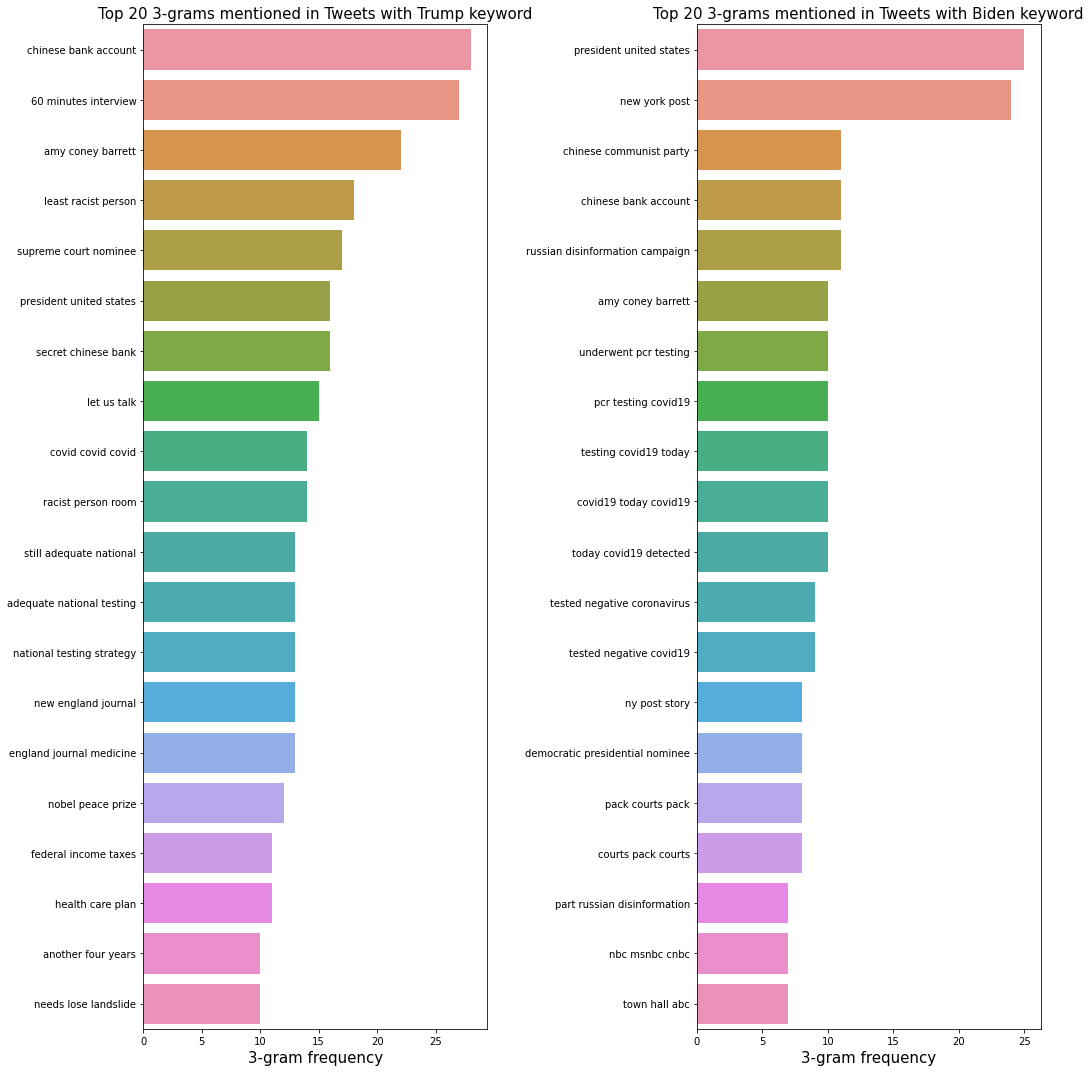

In [31]:
plot_comparison_top_ngrams_barcharts(
    text1=trump_df['tokenized_tweet'], 
    text2=biden_df['tokenized_tweet'],
    top_size=20,
    n=3  
)

## **Step 6 - Network Analysis**

In [32]:
# Defining the network plot function for saving the resultant network graph

def plot_network(graph, file_name, colors):
    print("Plotting the network graph...")
    sizes = np.array(list(dict(graph.degree).values())) * 10

    fig = plt.figure(1, figsize=(10, 10), dpi=300)
    plt.axis('off')
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph, pos, node_size=500, node_color=colors)
    nx.draw_networkx_edges(graph, pos)
    nx.draw_networkx_labels(graph, pos, font_size=4)

    xmax = max(xx for xx, yy in pos.values())
    ymax = max(yy for xx, yy in pos.values())
    xmin = min(xx for xx, yy in pos.values())
    ymin = min(yy for xx, yy in pos.values())
    plt.xlim(xmin-0.1, xmax+0.1)
    plt.ylim(ymin-0.1, ymax+0.1)

    plt.tight_layout()
    plt.savefig(file_name, bbox_inches="tight")
    plt.close()
    del fig

In [33]:
# Defining the function to take n_grams from tweets

def get_ngrams(text, main_keyword, n=2):
    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = []

        for word, idx in vec.vocabulary_.items():
            drop_word_detected = False

            for drop_word in DROP_WORDS:
                if drop_word in word:
                    drop_word_detected = True

            if drop_word_detected:
                continue

            words_freq.append((word, sum_words[0, idx]))

        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq

    n_grams = _get_top_ngram(text, n)
    n_grams.insert(0, (main_keyword, 1e5))

    return n_grams

def cut_by_threshold(n_grams,  threshold):
    new_n_grams = []

    for n_gram, count in n_grams:
        if count >= threshold:
            new_n_grams.append([n_gram, count])

    return new_n_grams

In [34]:
# Building the pipeline for creating a network using NetworkX

def get_nodes_and_edges(df, n_grams):
    print("Creating nodes and edges...")
    nodes = [(k, v) for k, v in n_grams]
    edges = []

    for tweet in df['tokenized_tweet']:
        for i in range(len(nodes)-1):
            if nodes[i][0] in tweet:
                for j in range(i+1, len(nodes)):
                    if nodes[j][0] in tweet and nodes[i][0] != nodes[j][0]:
                        edges.append((nodes[i][0], nodes[j][0]))

    nodes = {k: v for k, v in nodes}

    return nodes, edges

def define_colors(nodes, color_levels):
    print("Assign colors to nodes...")
    colors = []

    for node, value in nodes.items():
        for color_level in color_levels:
            if color_level[1] is None:
                colors.append(color_level[0])
            elif value >= color_level[1]:
                colors.append(color_level[0])
            break
        
    return colors

def build_network(df, n_grams, color_levels, file_name):
    nodes, edges = get_nodes_and_edges(df, n_grams)
    colors = define_colors(nodes, color_levels)

    print(f'Number of nodes: {len(nodes)}')
    print(f'Number of edges: {len(edges)}')
    print(f'Building the graph...')

    G = nx.Graph()
    G.add_nodes_from(nodes.keys())
    G.add_edges_from(edges)

    plot_network(G, file_name, colors)

    print(f'Success! The graph is built under the name {file_name}!')

In [35]:
# Getting trigrams for the Trump dataframe

trump_n_grams = get_ngrams(text=trump_df['tokenized_tweet'], main_keyword='trump', n=3)
trump_n_grams = cut_by_threshold(trump_n_grams, threshold=4)

In [36]:
# Getting trigrams for the Biden dataframe

biden_n_grams = get_ngrams(text=biden_df['tokenized_tweet'], main_keyword='biden', n=3)
biden_n_grams = cut_by_threshold(biden_n_grams, threshold=4)

In [37]:
# Defining the function to plot the frequency of trigrams in Tweets

def frequency_plot(n_grams, color):
    data = {k: v for k, v in n_grams[1:]}
    plt.subplots(figsize=(20, 10))
    plt.bar(x=data.keys(), height=data.values(), color=color)
    plt.xticks(rotation=90)
    plt.title('Frequency plot of N-grams in tweets', fontsize=20)
    plt.ylabel('Frequency', fontsize=15)
    plt.xlabel('N-grams', fontsize=15)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show();

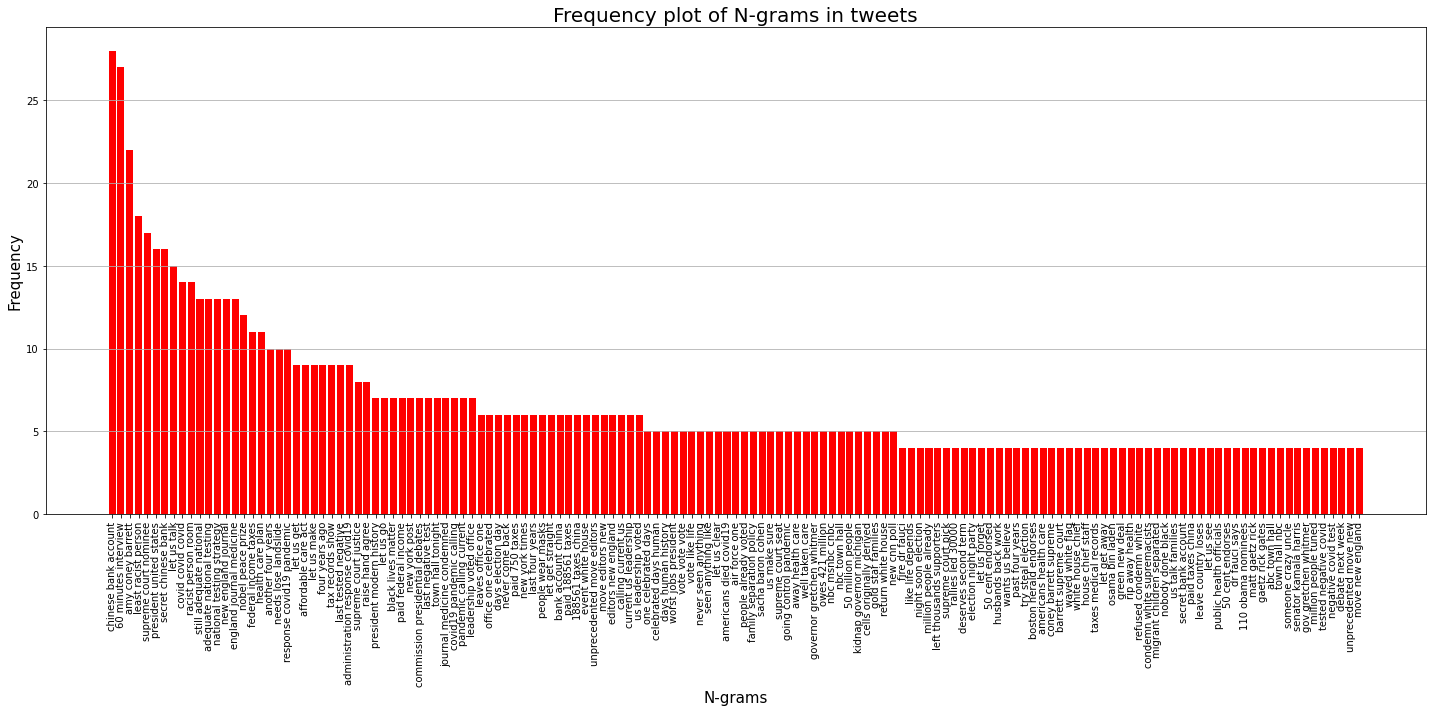

In [38]:
# Frequency plot for N-grams in Tweets about Trump

frequency_plot(trump_n_grams, color='red')

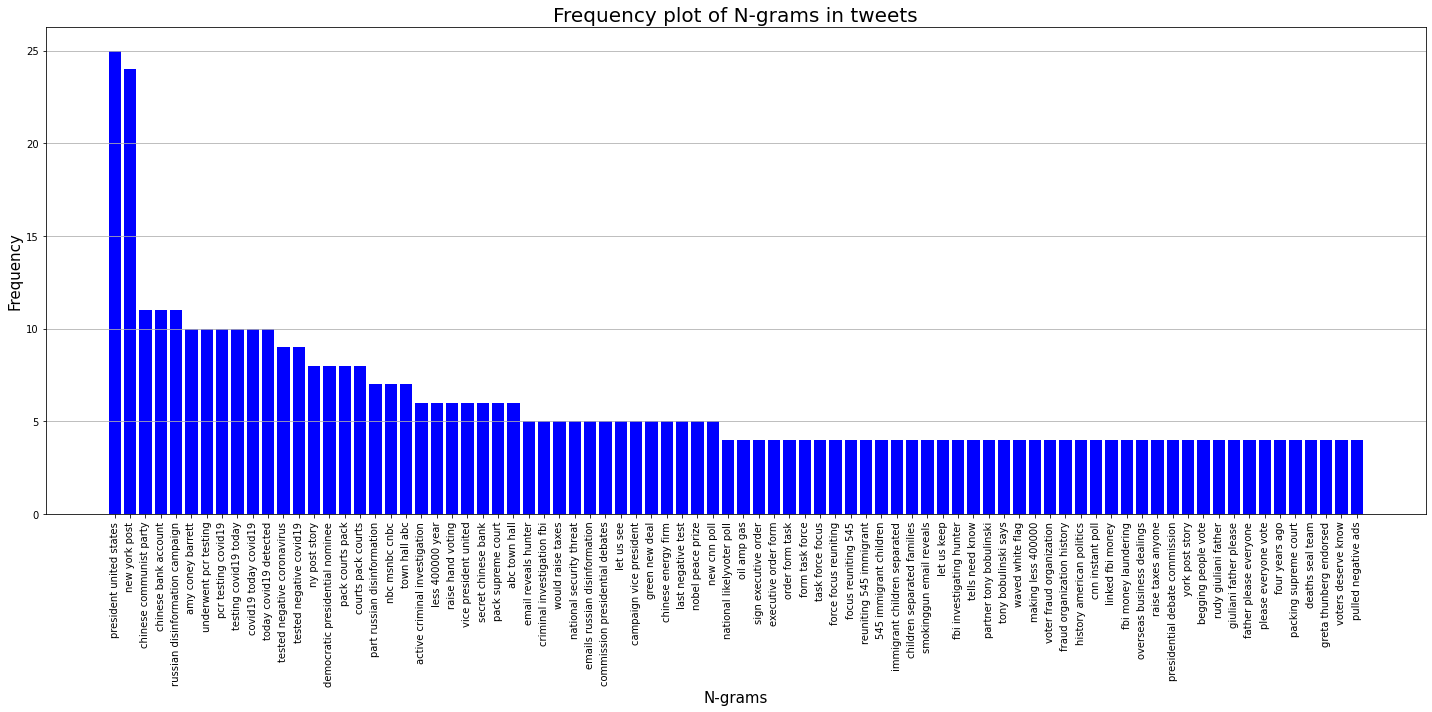

In [39]:
# Frequency plot for N-grams in Tweets about Biden

frequency_plot(biden_n_grams, color='blue')

In [40]:
# Manually defining thresholds for node colors based on frequency plots for the Trump network

trump_color_levels = [
  ('red', 15),
  ('orange', 10),
  ('yellow', 5),
  ('blue', None)
]

In [41]:
# Manually defining thresholds for node colors based on frequency plots for the Biden network

biden_color_levels = [
  ('red', 11),
  ('orange', 8),
  ('yellow', 5),
  ('blue', None)
]

In [42]:
# Building a network graph for the Trump dataframe

build_network(trump_df, trump_n_grams, color_levels=trump_color_levels, file_name='trump.pdf')

Creating nodes and edges...
Assign colors to nodes...
Number of nodes: 144
Number of edges: 1809
Building the graph...
Plotting the network graph...
Success! The graph is built under the name trump.pdf!


In [43]:
# Building a network graph for the Biden dataframe

build_network(biden_df, biden_n_grams, color_levels=biden_color_levels, file_name='biden.pdf')

Creating nodes and edges...
Assign colors to nodes...
Number of nodes: 83
Number of edges: 893
Building the graph...
Plotting the network graph...
Success! The graph is built under the name biden.pdf!
